In [8]:
import pandas as pd

from pathlib import Path


from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score

In [9]:
datafolder = Path('./datasets')
filename = 'concrete.csv'

df = pd.read_csv(datafolder/filename)
df.head()

,Cement,BlastFurnaceSlag,FlyAsh,Water,Superplasticizer,CoarseAggregate,FineAggregate,Age,CompressiveStrength
0,540.0,0.0,0.0,162.0,2.5,1040.0,676.0,28,79.99
1,540.0,0.0,0.0,162.0,2.5,1055.0,676.0,28,61.89
2,332.5,142.5,0.0,228.0,0.0,932.0,594.0,270,40.27
3,332.5,142.5,0.0,228.0,0.0,932.0,594.0,365,41.05
4,198.6,132.4,0.0,192.0,0.0,978.4,825.5,360,44.30


In [10]:
# Determine baseline
X = df.copy()
y = X.pop('CompressiveStrength')

In [11]:
# Train and score baseline model
baseline = RandomForestRegressor(criterion='absolute_error', random_state=0)
baseline_score = cross_val_score(
    baseline, X, y, cv=5, scoring="neg_mean_absolute_error"
)

baseline_score = -1 * baseline_score.mean()

print(f"MAE Baseline Score: {baseline_score:.4}")

MAE Baseline Score: 8.232


In [12]:
# AAdd three new ratio features
X = df.copy()
y = X.pop('CompressiveStrength')

# Create synthetic features
X['FCRatio'] = X['FineAggregate'] / X['CoarseAggregate']
X['AggCmtRatio'] = (X['CoarseAggregate'] + X['FineAggregate']) / X['Cement']
X['WtfCmtRatio'] = X['Water'] / X['Cement']

# train and score model on dataset with additional readion features
model = RandomForestRegressor(criterion='absolute_error', random_state=0)
score = cross_val_score(
    model, X, y, cv=5, scoring="neg_mean_absolute_error"
)
score = -1 * score.mean()

print(f"MAE Score with Ratio Features: {score:.4}")


MAE Score with Ratio Features: 7.948


## Mutual Information

**Mutual Information** (MI) between 2 quantities is a measure of the extent to which knowledge of one quantity reduces uncertainty about the other. 

- MI can help understand the relative potential of a feature as a predictor target
- It is a univariate metric. It can't detect interactions between features but can be very informative when interacting with other features
- Actual usefulness depends on the model it is used with

### Example - 1985 Automobiles

In [15]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# plt.style.use("seaborn-whitegrid")

autos = 'autos.csv'

df = pd.read_csv(datafolder/autos)
df.head()

,symboling,make,fuel_type,aspiration,num_of_doors,body_style,drive_wheels,engine_location,wheel_base,length,...,engine_size,fuel_system,bore,stroke,compression_ratio,horsepower,peak_rpm,city_mpg,highway_mpg,price
0,3,alfa-romero,gas,std,2,convertible,rwd,front,88.6,168.8,...,130,mpfi,3.47,2.68,9,111,5000,21,27,13495
1,3,alfa-romero,gas,std,2,convertible,rwd,front,88.6,168.8,...,130,mpfi,3.47,2.68,9,111,5000,21,27,16500
2,1,alfa-romero,gas,std,2,hatchback,rwd,front,94.5,171.2,...,152,mpfi,2.68,3.47,9,154,5000,19,26,16500
3,2,audi,gas,std,4,sedan,fwd,front,99.8,176.6,...,109,mpfi,3.19,3.40,10,102,5500,24,30,13950
4,2,audi,gas,std,4,sedan,4wd,front,99.4,176.6,...,136,mpfi,3.19,3.40,8,115,5500,18,22,17450


In [16]:
X = df.copy()
y = X.pop("price")

# Label encoding for categoricals
for colname in X.select_dtypes("object"):
    X[colname], _ = X[colname].factorize()

# All discreted features should now have integer dtypes
# Double check before using MI
discrete_features = X.dtypes == int

In [20]:
from sklearn.feature_selection import mutual_info_regression

def make_mi_scores(X, y, discrete_features):
    mi_scores = mutual_info_regression(X, y, discrete_features=discrete_features)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores

mi_scores = make_mi_scores(X, y, discrete_features)
mi_scores[::3]  # show a few features with MI scores

curb_weight          0.914672
horsepower           0.886649
length               0.603466
fuel_system          0.464689
num_of_cylinders     0.332440
symboling            0.234642
compression_ratio    0.106334
body_style           0.043441
Name: MI Scores, dtype: float64

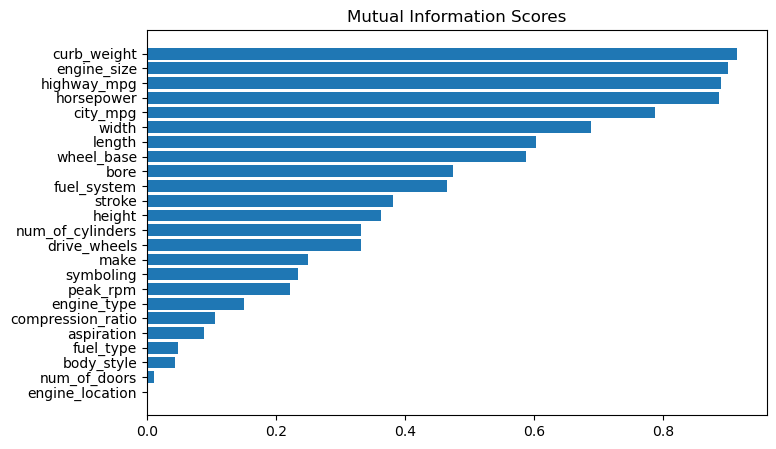

In [21]:
def plot_mi_scores(scores):
    scores = scores.sort_values(ascending=True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.barh(width, scores)
    plt.yticks(width, ticks)
    plt.title("Mutual Information Scores")

    
plt.figure(dpi=100, figsize=(8, 5))
plot_mi_scores(mi_scores)

c:\Users\manuel.clemente\Anaconda3a\envs\MSADS-ML_20240405\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\manuel.clemente\Anaconda3a\envs\MSADS-ML_20240405\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\manuel.clemente\Anaconda3a\envs\MSADS-ML_20240405\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\manuel.clemente\Anaconda3a\envs\MSADS-ML_20240405\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categoric

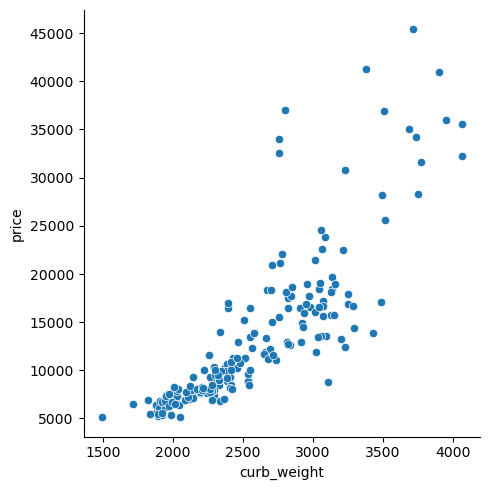

In [23]:
sns.relplot(x="curb_weight", y="price", data=df)

c:\Users\manuel.clemente\Anaconda3a\envs\MSADS-ML_20240405\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\manuel.clemente\Anaconda3a\envs\MSADS-ML_20240405\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


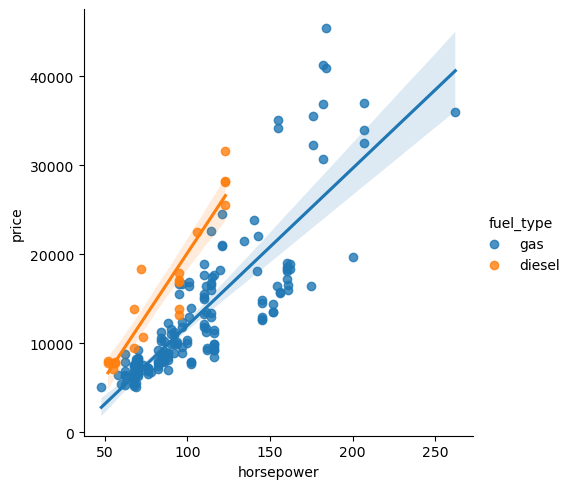

In [24]:
sns.lmplot(x="horsepower", y="price", hue="fuel_type", data=df)